In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib as mpl
from cycler import cycler
from pandas import read_csv

from ucla.core.constants import *
from ucla.core.physics import SMT#, JT_GMS
from ucla.core.exp_setup import Cylindrical_Grid, Experiment, Measurements
from ucla.core.Hydro_solver import HydroModel
from ucla.core.config import PACKAGE_DIR, CORE_DIR

from scipy.optimize import root, curve_fit, least_squares
from scipy.interpolate import interp1d

import cProfile


mpl.rcParams['lines.linewidth'] = 2.2
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['font.sans-serif'] = ['Arial', 'Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana']
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = '#636363'
mpl.rcParams['grid.alpha'] = 0.12
mpl.rcParams['grid.linewidth'] = 0.7
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['axes.prop_cycle'] = cycler('color',  ['#0AB34F', '#bf009f', '#00abc3', '#8e92c5', '#cc7014', '#e32851'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.framealpha'] = 0.6
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.figsize'] = 8, 4.9443
mpl.rcParams['figure.dpi'] = 100

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


# Argon Profile Data
 
Based on 
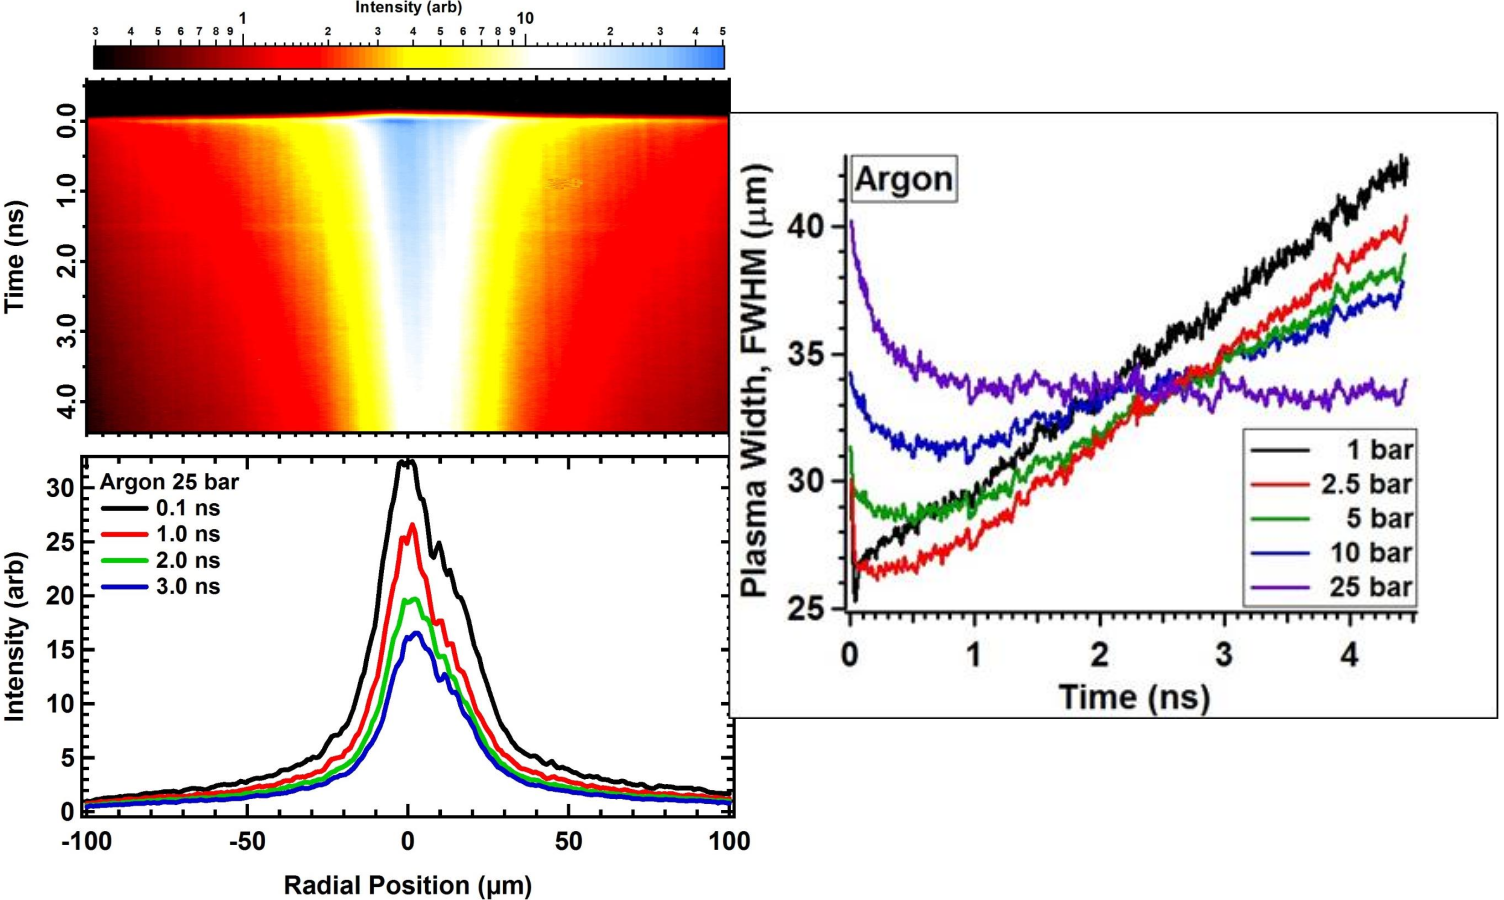

# Experimental Setup

In [2]:
# Argon information
Z, A = 18, 40
nn_invcc_at_Pbar_TK = lambda Pbar, TK: Pbar*bar_to_AU/(TK*K_to_AU)*AU_to_invcc
T_room_K = 290
Ar_nn_invcc = nn_invcc_at_Pbar_TK(25, T_room_K)
n0 = Ar_nn_invcc*1e6

Ar_ionization_energies_eV = np.array([0, 15.7596119, 27.62967, 40.735, 59.58, 74.84, 91.290])
Ar_TK_peak = 17.761029411764707e3 # 0.008097165991902834 ns?

print(f"Ar ne = {Ar_nn_invcc:0.3e} [1/cc], Te_peak= {Ar_TK_peak*1e-3:0.3f} kK ")

Ar_data = read_csv(PACKAGE_DIR + "/data/experimental_data/Ar_25bar_Te.txt", delim_whitespace=True, header=1)
Ar_FWHM_data = read_csv(PACKAGE_DIR + "/data/experimental_data/Ar_25bar_FWHM.txt", delim_whitespace=True, header=1)

# dih_file = PACKAGE_DIR + "/data/Ar25bar_DIH_profile_data.txt"
saha_file = PACKAGE_DIR + "/data/Ar25bar_Saha.txt"

grid  = Cylindrical_Grid(100e-6, N=500) 
model_kwargs = {'gas_name':'Argon', 'model':"SMT", 'ionization_model':'input', 'ionization_file': saha_file, 'ion_temperature_model':'uniform','Ti_experimental_initial':T_room_K,
                'electron_temperature_model':'gaussian','Te_experiment_is_peak':True, 'super_gaussian_power':1}

Ar ne = 6.244e+20 [1/cc], Te_peak= 17.761 kK 


### Fit to Initial Experimental Values

In [3]:
###m NEED TO FIX

# import warnings
# # Suppress warnings from fitting initial conditions
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     def fit_initial_condition(Te_exp, FWHM_exp , **kwargs ):
#         def find_exp_params(inputs):
#             Te_peak, Te_FWHM = inputs
#             Argon_jt = Experiment(grid, n0, Z, A, Te_peak, Te_FWHM, **kwargs)

#             ttm = HydroModel(Argon_jt, model=kwargs['model'])
#             exp = Measurements(Z, A, ttm.grid.r, ttm.n_e, ttm.n_i, ttm.Te, ttm.Ti, R_max = 100e-6, Nx =100, Nz=100)
#             return Te_exp - exp.Te_fit, FWHM_exp - exp.FWHM 
# #         sol = root(find_exp_params, (Te_exp, 2*FWHM_exp))
#         sol = root(find_exp_params, (0.9*Te_exp, 110e-6))
#         return sol

#     initial_conditions = fit_initial_condition(Ar_data['T[kK]'][0]*1e3, Ar_FWHM_data['FWHM[μm]'][0]/1e6,**model_kwargs)
# # Show success of initial condition fit     
# print(initial_conditions)
# Te_initial, gaussian_FWHM = initial_conditions.x
# Argon = Experiment(grid, n0, Z, A, Te_initial, gaussian_FWHM, **model_kwargs)

# ttm = HydroModel(Argon, model = model_kwargs["model"])

# # Print Setup
# initial_setup = Measurements(Z, A, ttm.grid.r, ttm.n_e, ttm.n_i, ttm.Te, ttm.Ti, R_max = 200e-6, Nx =200, Nz=100)
# print("\nExp: FWHM = {0:.2f} [μm], Te = {1:.2f} [kK]".format(Ar_FWHM_data['FWHM[μm]'][0], Ar_data['T[kK]'][0]))
# print("Sim: FWHM = {0:.2f} [μm], Te = {1:.2f} [kK]".format(initial_setup.FWHM*1e6,initial_setup.Te_fit/1e3))

In [4]:
Te_initial, gaussian_FWHM = 1.2*Ar_TK_peak, 50e-6
Argon = Experiment(grid, n0, Z, A, Te_initial, gaussian_FWHM, **model_kwargs)

ttm = HydroModel(Argon, model = model_kwargs["model"])

# Print Setup
initial_setup = Measurements(Z, A, ttm.grid.r, ttm.n_e, ttm.n_i, ttm.Te, ttm.Ti, R_max = 200e-6, Nx =300, Nz=600)
print("\nExp: FWHM = {0:.2f} [μm], Te = {1:.2f} [kK]".format(Ar_FWHM_data['FWHM[μm]'][0], Ar_data['T[kK]'][0]))
# print("Sim: FWHM = {0:.2f} [μm], Te = {1:.2f} [kK]".format(initial_setup.FWHM*1e6,initial_setup.Te_fit/1e3))

Using gaussian model for Ti: Ti_max = 2.900e+02 K


/home/zach/plasma/ucla/core/physics.py:306: RuntimeWarning: invalid value encountered in sqrt
  l_mfp = c/ν_ω * np.sqrt(1-γ)/γ
/home/zach/plasma/ucla/core/physics.py:358: RuntimeWarning: overflow encountered in exp
  B_λ = 4*π*hbar * c**2/λ**5 * 1/(np.exp(2*π*hbar*c/(λ*k_B*Te))-1)



Exp: FWHM = 39.90 [μm], Te = 17.76 [kK]


### Plotting Initial Experimental Setup

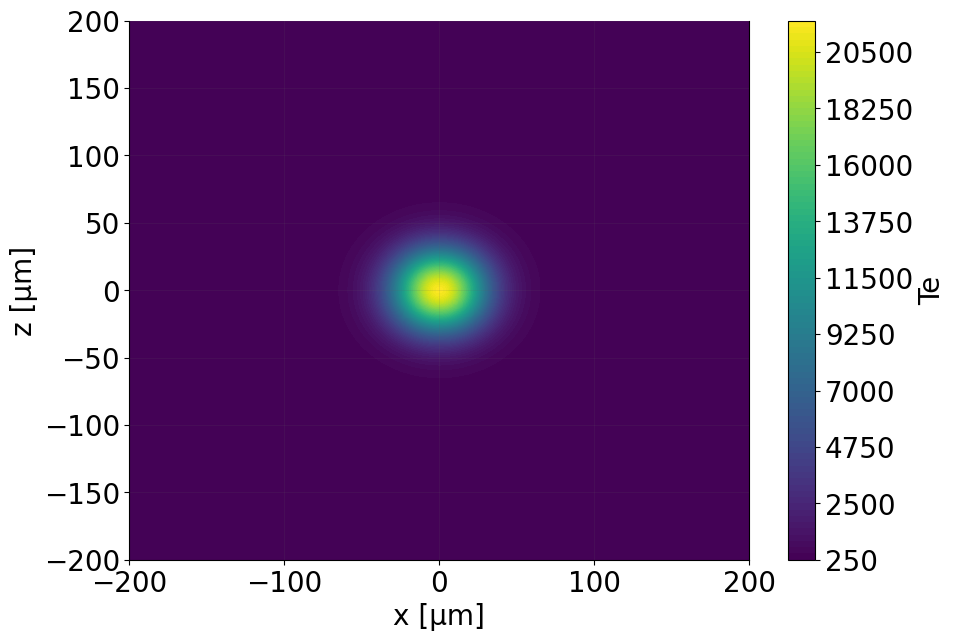

In [5]:
initial_setup.plot_parameter(initial_setup.Te_grid, "Te")

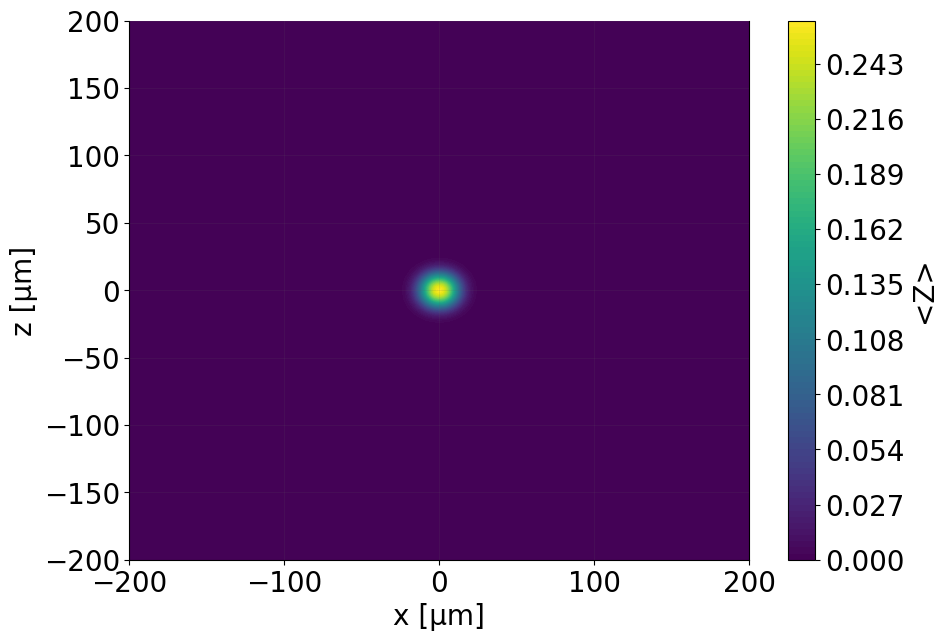

In [6]:
initial_setup.plot_parameter(initial_setup.Zbar_grid, "<Z>")

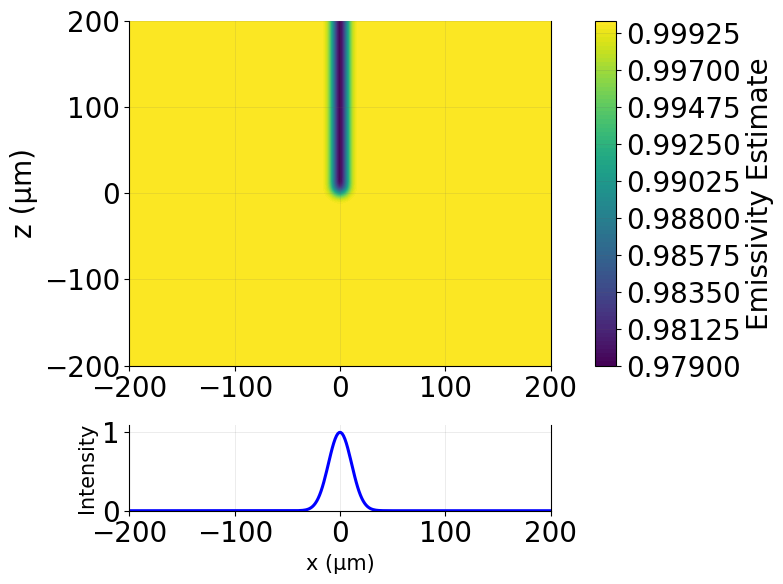

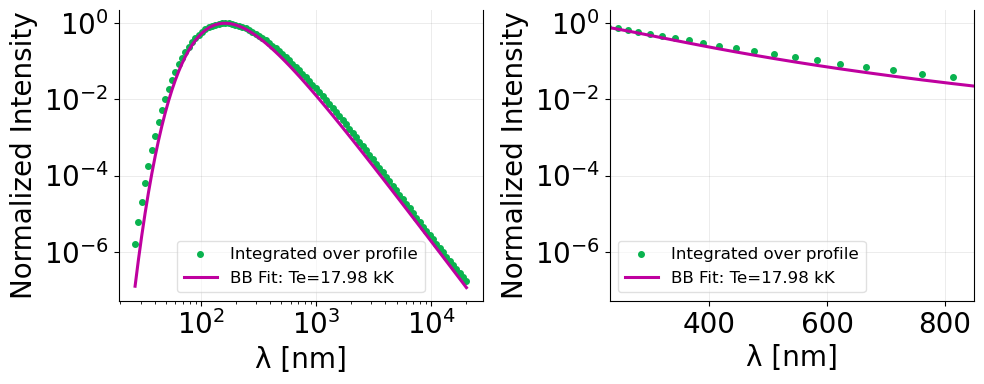

In [7]:
initial_setup.plot_emissivity_and_intensity()
initial_setup.plot_spectral_Intensity()

# Run Hydrodynamic Simulation

In [17]:
%%time
ttm.solve_hydro(tmax=5e-9, dt=1e-11)

WARNING, Zbar minimizer not converge.
 message: The number of calls to function has reached maxfev = 2000.
 success: False
  status: 2
     fun: [ 3.762e-06  3.790e-06 ...  0.000e+00  0.000e+00]
       x: [ 2.144e+04  2.144e+04 ...  3.003e+02  3.003e+02]
    nfev: 2012
    fjac: [[-1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00 -1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ... -1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00 -1.000e+00]]
       r: [-3.504e+01  0.000e+00 ...  0.000e+00 -1.000e+00]
     qtf: [-3.762e-06 -3.790e-06 ...  0.000e+00  0.000e+00]
Worst point is at index = 82, r=1.6432865731462926e-05, fun = 0.29094901489406766, Te = 16090.239778054785 
Fail Zbar, breaking.
CPU times: user 8min, sys: 315 ms, total: 8min 1s
Wall time: 8min


In [18]:
ttm.t_saved_list

[0.0,
 1e-11,
 2e-11,
 3e-11,
 4e-11,
 4.9999999999999995e-11,
 6e-11,
 6.999999999999999e-11,
 8e-11,
 9e-11,
 9.999999999999999e-11,
 1.1e-10]

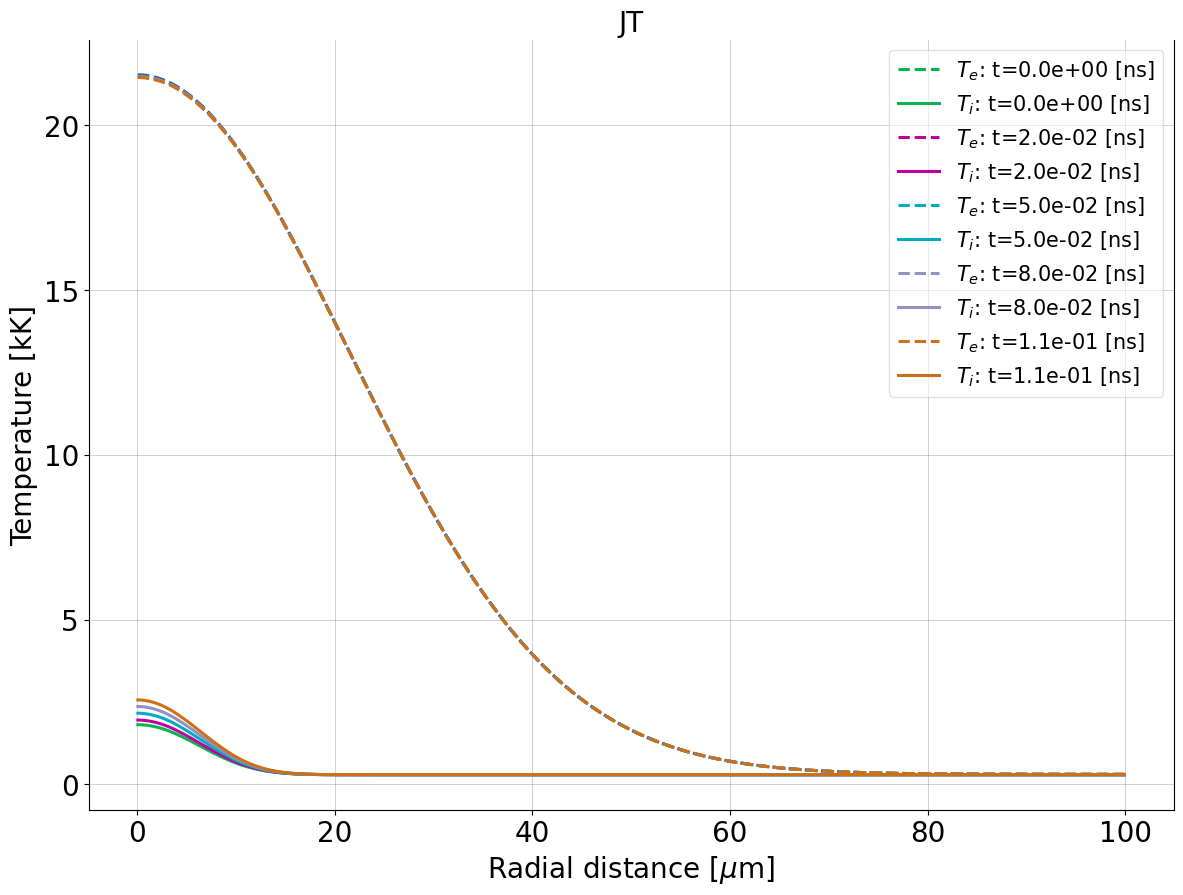

In [19]:
def plot_temp_profiles(ttm, plot_times = None, ax = None, title='', normalized=False):

    if plot_times is None:
        plot_times = (np.linspace(0,len(ttm.t_saved_list)*0.99,num=5,endpoint=True)).astype(int)  # Intermediate times for plotting        
        
    # Plot temperature profiles at intermediate times
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,10),facecolor='w')
    
    
        
    plot_idx = 0
    for plot_idx, ti in enumerate(plot_times):
        t = ttm.t_saved_list[ti]
        if normalized==True:
            ax.plot(grid.cell_centers*1e6, ttm.Te_list[ti][:-1]/ttm.Te_list[ti][0], '--', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
            ax.plot(grid.cell_centers*1e6, ttm.Ti_list[ti][:-1]/ttm.Ti_list[ti][0], '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
        else:
            ax.plot(grid.cell_centers*1e6, ttm.Te_list[ti][:-1]*1e-3, '--', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
            ax.plot(grid.cell_centers*1e6, ttm.Ti_list[ti][:-1]*1e-3, '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
            # ax.plot(grid.cell_centers*1e6, ttm.v_list[ti][:-1], '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
#             ax.plot(grid.cell_centers*1e6, (ttm.n__list[ti][:-1])/(ttm.n_i_list[ti][:-1]), '.', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
#             ax.plot(grid.cell_centers*1e6, (ttm.Te_list[ti][1:])-(ttm.Te_list[ti][:-1]), '.', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
#             ax.plot(grid.cell_centers*1e6, (ttm.Ti_list[ti][1:])-(ttm.Ti_list[ti][:-1]), '.', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
            
        # plot_idx += 1


    # Plot settings
    ax.set_xlabel(r"Radial distance [$\mu$m]",fontsize=20)
    ax.set_ylabel("Temperature [kK]",fontsize=20)
    ax.tick_params(labelsize=20)
#     ax.set_xlim(55,85)
#     ax.set_ylim(0,3)
#     ax.set_yscale('log')
    ax.legend(fontsize=15)
    ax.grid(alpha = 0.3)
    ax.set_title(title, fontsize=20)

    
fig, ax = plt.subplots(1,1, figsize=(14,10),facecolor='w')
ax = np.array([ax])
plot_temp_profiles(ttm, ax = ax[0], title='JT', normalized=False, plot_times=None)#[12,13,14])


In [ ]:
ttm.t_saved_list[30]
ttm.v_list[30]

### Process Experimental Results at all times 

In [ ]:
%%time
FWHM_list = []
FWHM_indices = list(range(len(ttm.t_saved_list)))[::1]
FWHM_t_list = [] 
Te_fit_list = []
Intensity_list = []

for i in FWHM_indices:#[:1400][::100]):
    exp_i = Measurements(Z, A, ttm.grid.r, ttm.n_e_list[i], ttm.n_i_list[i], ttm.Te_list[i], ttm.Ti_list[i], R_max = 100e-6, Nx = 100, Nz=100)
    FWHM_list.append(exp_i.FWHM)
    Te_fit_list.append(exp_i.Te_fit)
    FWHM_t_list.append(ttm.t_saved_list[i])
    Intensity_list.append(exp_i.I_of_r_fit*np.max(exp_i.I_unnormalized_of_r))

# Comparison to Experiment
### Functions to Fit To

In [ ]:
def Texp_fit_form(t, Te_0, Ti_0, d, τei):
    ΔT0 = (Te_0-Ti_0)
    ΣT0 = (Te_0+Ti_0)
    return ΣT0/2 - d*t + ΔT0/2*np.exp(-2*t/τei)

def T_fit_form(t, T0, ΔT, τei, τ_switch, t01,dTdt):
    return T0 + ΔT*np.exp(-2*t/τei) + (1-1/(1+np.exp( (t-t01)/τ_switch )))* dTdt

# def T_fit_form(t, T0, a, b, c):
#     return T0*1/(1+c**2*t**2) + a*np.exp(-2*t/b) 

def FWHM_adiabatic_fit_form(t, FWHM_0, vf):
    return np.sqrt(FWHM_0**2 + vf**2*t**2 ) 

def FWHM_fit_form(t, FWHM_0, vf, a, b, c, d, t0):
    return np.sqrt(FWHM_0**2 + vf**2*t**2 ) + (1/(1+np.exp( a*(t-t0))))* (b*t+ c)#+ d

Te_vals   = curve_fit(Texp_fit_form, Ar_data['t[ns]'], Ar_data['T[kK]'] ,maxfev=int(1e5))[0]#, -6.22682412e+03])[0]
FWHM_vals = curve_fit(FWHM_fit_form, Ar_FWHM_data['t[ns]'], Ar_FWHM_data['FWHM[μm]'] ,maxfev=int(1e4),p0=[47.79699697,  2.534726490,  0.5,  -5, 1, 5, 0.2])[0]
FWHM_sim_vals = curve_fit(FWHM_fit_form, np.array(FWHM_t_list)*1e9,np.array(FWHM_list)*1e6 ,maxfev=int(1e5),p0=(47.79699697,  2.534726490,  0.5,  -5, 1, 5, 0.2))[0]
Te_sim_vals = curve_fit(T_fit_form, np.array(FWHM_t_list)*1e9,np.array(Te_fit_list)/1e3 ,maxfev=int(1e5))[0]

Te_sim_vals, FWHM_sim_vals

### Show Agreement with Experiment

In [ ]:
fig, ax = plt.subplots(figsize=(10,8), facecolor='white')
fig.suptitle("Full Experimental Fit and Simulation in Xe at 5 bar", fontsize=20)

dense_t_list = np.linspace(0,18,num=100)

# Plot Te
#Data and fit
ax.plot(Ar_data['t[ns]'], Texp_fit_form(Ar_data['t[ns]'],*Te_vals), 'r--', label='Experiment Data')
ax.plot(Ar_data['t[ns]'], Ar_data['T[kK]'], 'rx', label='Experiment Data')
# Simulation and Fit
ax.plot(np.array(FWHM_t_list)*1e9, np.array(Te_fit_list)/1e3,'r.')
ax.plot(dense_t_list, T_fit_form(dense_t_list,*Te_sim_vals),'r-')
# Extra
# ax.plot(np.array(FWHM_t_list)*1e9, T_fit_form(np.array(FWHM_t_list)*1e9,*Te_sim_vals),'r-')
# ax.plot(np.array(FWHM_t_list)*1e9, np.array(Te_fit_list)/1e3,'.', color='r', )


ax.set_ylabel(r'$T_e$ [kK]', fontsize=20, color='r')
ax.set_xlabel('t [ns]', fontsize=20)
# ax.set_xlim(0,12)

# ax.set_ylim(40,60)
ax.tick_params(labelsize=20)
ax.tick_params(axis='y',color='r', labelcolor='r')

ax2 = ax.twinx()
# Plot FWHM
#Data and fit
ax2.plot(Ar_FWHM_data['t[ns]'], Ar_FWHM_data['FWHM[μm]'], 'kx', label='Experiment Data')
ax2.plot(Ar_FWHM_data['t[ns]'], FWHM_fit_form(Ar_FWHM_data['t[ns]'],*FWHM_vals),'k--')
# Simulation and Fit
ax2.plot(np.array(FWHM_t_list)*1e9, np.array(FWHM_list)*1e6,'.k')
ax2.plot(dense_t_list, FWHM_fit_form(dense_t_list,*FWHM_sim_vals),'k-')



ax2.set_ylabel('FWHM [$\mu$m]', fontsize=20)
ax2.tick_params(labelsize=20)
# ax.set_xscale('log')
# ax2.set_yscale('log')
# ax.set_xlim(0,3)

### Intensity Contour Map

In [ ]:
# Make a meshgrid for the contour plot
X, T = np.meshgrid(exp_i.x*1e6, np.array(FWHM_t_list[::-1])*1e9, indexing='ij')

# Create a custom colormap going from black at 0 to red at 0.5 to blue at 1
cmap = plt.cm.colors.LinearSegmentedColormap.from_list("", ["black","red","yellow","white","lightskyblue"])

fig, ax = plt.subplots(figsize=(10,8))

# Create the contour plot
contour = ax.contourf(X, T, 1.1*np.array(Intensity_list).T/np.max(Intensity_list), levels=100, cmap=cmap)

# Label the axes
ax.set_xlabel('x [μm]', fontsize=20)
ax.set_ylabel('t [ns]', fontsize=20)
ax.tick_params(labelsize=20)

# Add a color bar
cbar = plt.colorbar(contour)
cbar.set_label('Intensity', size=20)
cbar.ax.tick_params(labelsize=20)

plt.show()